In [1]:
RunInColab = 'google.colab' in str(get_ipython())
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Installing missing packages
'''!pip install optuna
!pip install catboost
!pip install xgboost
!pip install lightgbm'''
!pip install roman

#Imports
import os
import stat
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import optuna
import time
import importlib
import json
#import torch
#import lightgbm
#torch.autograd.set_detect_anomaly(False)
#torch.set_default_tensor_type(torch.DoubleTensor)
#torch.set_default_dtype(torch.float64)

#Importing sklearn models and metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler

#Importing TabNet Regressor model    
#from pytorch_tabnet.tab_model import  TabNetRegressor

np.random.seed(777)

#import pytorch_tabnet
#os.environ['tabnet'] = pytorch_tabnet.__path__.__dict__['_path'][0]
#os.environ['patchfile'] = os.path.abspath(os.path.join('Stark_ML', 'float64.patch'))
#if os.name == 'nt':
#    !cd /d %tabnet% & patch < "%patchfile%"
#else:
#    !cd $tabnet && patch -f < $patchfile
#importlib.reload(pytorch_tabnet)

if RunInColab:
    from google.colab import output
    def clear_output():
        output.clear()
else:
    from IPython import display
    def clear_output():
        display.clear_output()

clear_output()

In [46]:
#Download and import all utilities and models

import Stark_ML
import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet

importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)

from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
#from pytorch_tabnet.tab_model import  TabNetRegressor

new_rc_params = {'text.usetex': False,
                "svg.fonttype": 'none'
                }
plt.rcParams.update(new_rc_params)

clear_output()

# Ions data

In [4]:
#Import data for training and testing
data_a = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BF'
                   )
#Replace term symbols with quantum numbers
data_a['Term'] = term_to_number(data_a['Term'])
data_a['Term.1'] = term_to_number(data_a['Term.1'])

#Replace accuracy symbols with uncetrainty in %
data_a['w error (%)'] = uncertainty_to_number(data_a[data_a['w error (%)'].notna()]['w error (%)'])
data_a['d error (%)'] = uncertainty_to_number(data_a[data_a['d error (%)'].notna()]['d error (%)'])

In [5]:
#Import ions data for training and testing
data_i = pd.read_excel(Stark_ML.__path__.__dict__['_path'][0] + '/Source_files/Stark_data.xlsx',
                     sheet_name='Ions',
                     usecols='A:BQ'
                   )
#Replace term symbols with quantum numbers
data_i['Term'] = term_to_number(data_i['Term'])
data_i['Term.1'] = term_to_number(data_i['Term.1'])

#Replace accuracy symbols with uncetrainty in %
data_i['w error (%)'] = uncertainty_to_number(data_i[data_i['w error (%)'].notna()]['w error (%)'])
data_i['d error (%)'] = uncertainty_to_number(data_i[data_i['d error (%)'].notna()]['d error (%)'])

#Drop entries with levels' data unavailable
data_i = data_i[data_i['J'].notna()]
data_i = data_i[data_i['J.1'].notna()]

In [6]:
#Making sure that atoms and ions datasets have the same set of columns
for i, name in enumerate(data_i.columns):
    if name != data_a.columns[i]:
        if name in data_a.columns:
            print(f'renaming {name}')
            data_a = data_a.rename(columns = {name: name+'.1'})
        data_a.insert(i, data_i.columns[i], 0)
        print(data_i.columns[i])

Charge
5f
5g
renaming 6d
6d
renaming 7p
7p
5f.1
5g.1
6f
6g
6h
11s


In [7]:
#merging atoms and ions together
data = pd.concat([data_a, data_i], axis = 0, ignore_index = True)
data.insert(data.columns.get_loc('E upper')+1, 'Gap to ion', 0)
data['Gap to ion'] = gap_to_ion(data, 'E upper')

In [8]:
data_width = data[data['w (A)'].isna() == False]
data_shift = data[data['d (A)'].isna() == False]
data_both = data[(data['w (A)'].isna() == False) & (data['d (A)'].isna() == False)]

In [9]:
data

,Element,Wavelength,Z number,Charge,1s,2s,2p,3s,3p,3d,...,Term.1,Parity.1,J.1,E upper,Gap to ion,T,w (A),d (A),w error (%),d error (%)
0,He,2058.690,2,0,1,1,0,0,0,0,...,1,0,1.0,171134.894441,27176.105559,24400,15.324675,NaN,NaN,NaN
1,He,2058.690,2,0,1,1,0,0,0,0,...,1,0,1.0,171134.894441,27176.105559,25500,12.967033,NaN,NaN,NaN
2,He,2058.690,2,0,1,1,0,0,0,0,...,1,0,1.0,171134.894441,27176.105559,25500,11.515152,NaN,NaN,NaN
3,He,501.568,2,0,1,1,0,0,0,0,...,1,0,1.0,186209.364940,12101.635060,19000,8.800000,NaN,NaN,NaN
4,He,501.568,2,0,1,1,0,0,0,0,...,1,0,1.0,186209.364940,12101.635060,19100,8.042553,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6615,N,500.515,7,1,2,2,1,0,1,0,...,3,0,4.0,186652.490000,52097.510000,30300,0.325581,NaN,23.0,NaN
6616,N,500.147,7,1,2,2,1,0,1,0,...,3,0,3.0,186570.980000,52179.020000,30300,0.331395,NaN,23.0,NaN
6617,N,500.113,7,1,2,2,1,0,1,0,...,3,0,2.0,186511.580000,52238.420000,30300,0.302326,NaN,23.0,NaN
6618,N,501.638,7,1,2,2,1,0,1,0,...,3,0,2.0,186511.580000,52238.420000,30300,0.337209,NaN,23.0,NaN


## Chemical elements

In [48]:
data['Element'].nunique()

50

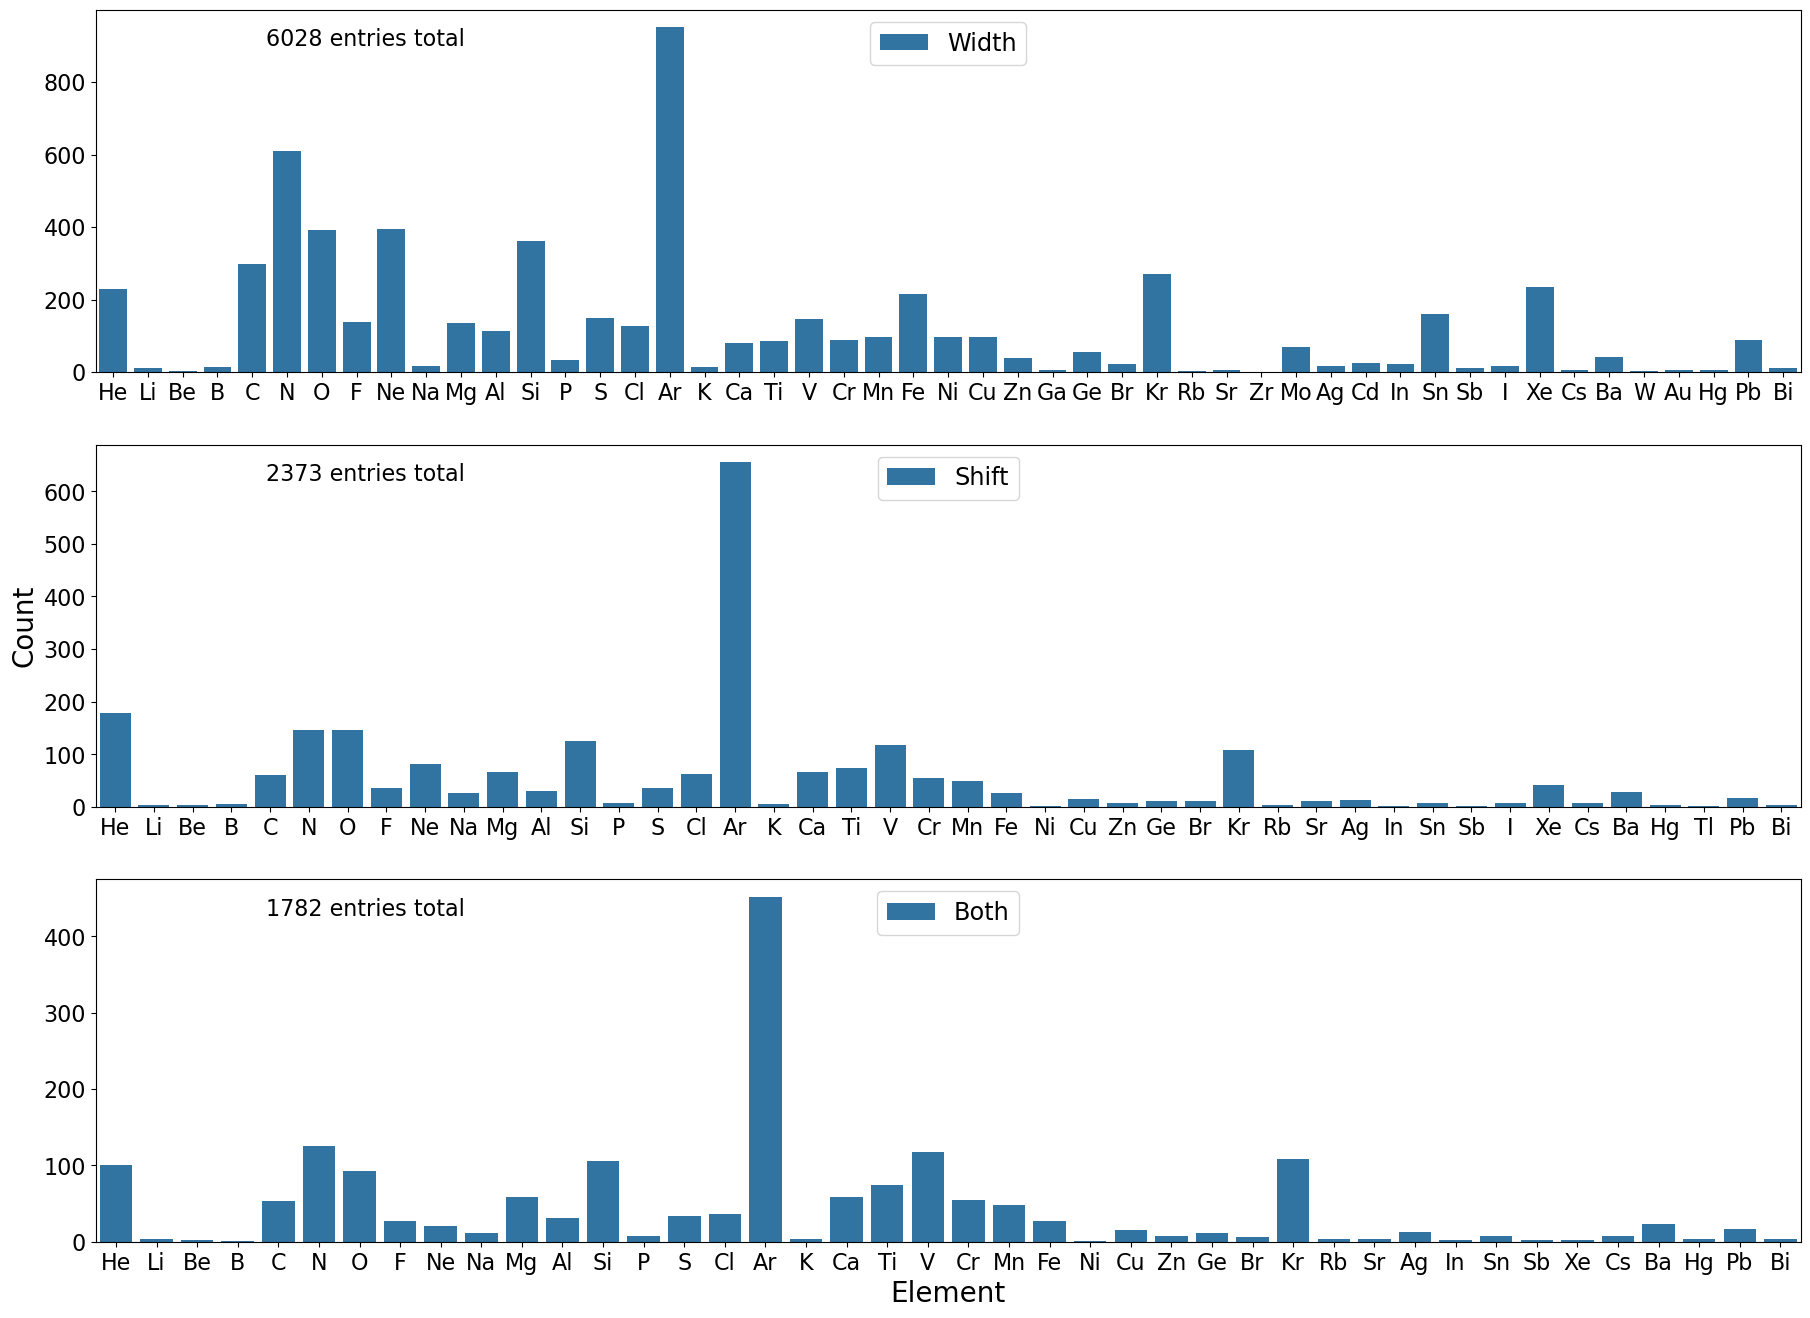

In [47]:
fig, ax = plt.subplots(3, 1, figsize = (22, 16), sharex = False)
sns.countplot(data = data_width.sort_values(by = ['Z number']), x = 'Element', ax = ax[0], label = 'Width')
sns.countplot(data = data_shift.sort_values(by = ['Z number']), x = 'Element', ax = ax[1], label = 'Shift')
sns.countplot(data = data_both.sort_values(by = ['Z number']), x = 'Element', ax = ax[2], label = 'Both')

for i in range(len(ax)):
    ax[i].legend(loc = 'upper center', fontsize = 'xx-large')
    ax[i].tick_params(axis = 'both', labelsize = 16)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)

ax[0].text(x = 0.1, y = 0.9, s = f'{data_width.shape[0]} entries total', transform=ax[0].transAxes, fontsize = 16)
ax[1].text(x = 0.1, y = 0.9, s = f'{data_shift.shape[0]} entries total', transform=ax[1].transAxes, fontsize = 16)
ax[2].text(x = 0.1, y = 0.9, s = f'{data_both.shape[0]} entries total', transform=ax[2].transAxes, fontsize = 16)
ax[2].set_xlabel('Element', fontsize = 20)
ax[1].set_ylabel('Count', fontsize = 20)

# plt.savefig('Elemets stats.svg', transparent = True)

plt.show()

## Charges

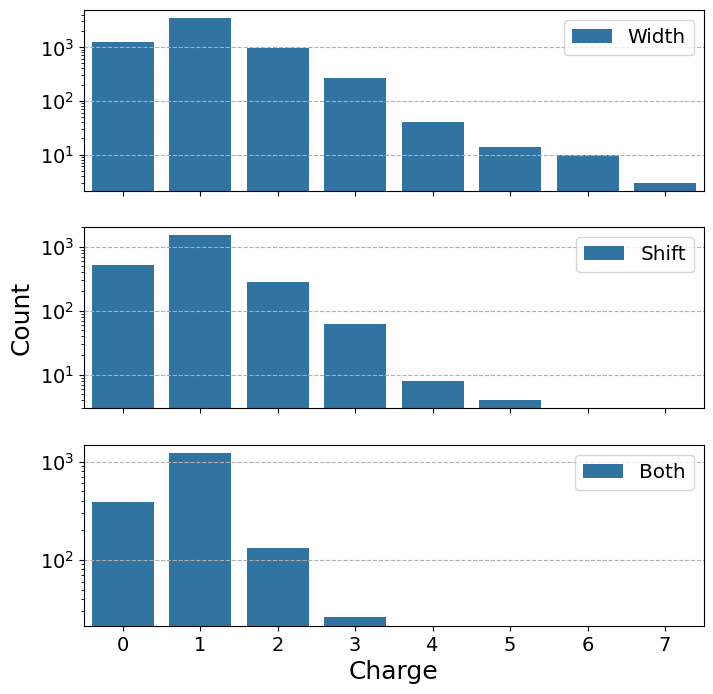

In [49]:
fig, ax = plt.subplots(3, 1, figsize = (8, 8), sharex = True)
sns.countplot(data = data_width, x = 'Charge', ax = ax[0], label = 'Width', log_scale = False)
sns.countplot(data = data_shift, x = 'Charge', ax = ax[1], label = 'Shift')
sns.countplot(data = data_both, x = 'Charge', ax = ax[2], label = 'Both')

for i in range(len(ax)):
    ax[i].legend(loc = 'upper right', fontsize = 'x-large')
    ax[i].tick_params(axis = 'both', labelsize = 14)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)

ax[2].set_xlabel('Charge', fontsize = 18)
ax[1].set_ylabel('Count', fontsize = 18)

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

ax[0].grid(which = 'major', axis = 'y', ls = '--')
ax[1].grid(which = 'major', axis = 'y', ls = '--')
ax[2].grid(which = 'major', axis = 'y', ls = '--')

# plt.savefig('Charges stats.svg', transparent = True)
plt.show()

## Energies

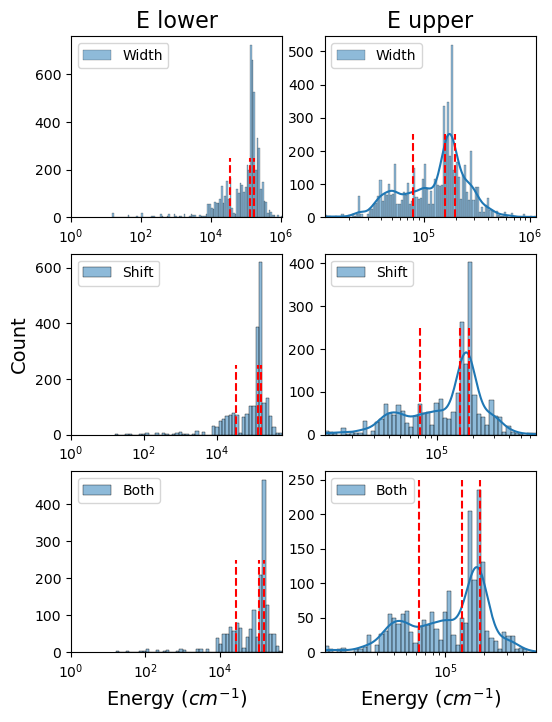

In [733]:
stat_width_low = data_width['E lower'].describe()
stat_width_up  = data_width['E upper'].describe()
stat_shift_low = data_shift['E lower'].describe()
stat_shift_up  = data_shift['E upper'].describe()
stat_both_low  = data_both['E lower'].describe()
stat_both_up   = data_both['E upper'].describe()

stats = [[stat_width_low, stat_width_up],
         [stat_shift_low, stat_shift_up],
         [stat_both_low, stat_both_up]]

fig, ax = plt.subplots(3, 2, figsize = (6, 8))

sns.histplot(data = data_width, x = 'E lower', ax = ax[0, 0], log_scale=True, bins = 100, kde = True, label = 'Width')
sns.histplot(data = data_width, x = 'E upper', ax = ax[0, 1], log_scale=True, bins = 100, kde = True, label = 'Width')
sns.histplot(data = data_shift, x = 'E lower', ax = ax[1, 0], log_scale=True, bins = 50, kde = True, label = 'Shift')
sns.histplot(data = data_shift, x = 'E upper', ax = ax[1, 1], log_scale=True, bins = 50, kde = True, label = 'Shift')
sns.histplot(data = data_both,  x = 'E lower', ax = ax[2, 0], log_scale=True, bins = 50, kde = True, label = 'Both')
sns.histplot(data = data_both,  x = 'E upper', ax = ax[2, 1], log_scale=True, bins = 50, kde = True, label = 'Both')

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i, j].set_xlabel(None)
        ax[i, j].set_ylabel(None)
        ax[i, j].legend()
        
        ax[i, j].vlines(stats[i][j]['25%'], 0, 250, 'r', ls = '--')
        ax[i, j].vlines(stats[i][j]['50%'], 0, 250, 'r', ls = '--')
        ax[i, j].vlines(stats[i][j]['75%'], 0, 250, 'r', ls = '--')
        
        ax[i, j].set_xlim(stats[i][j]['min']+1, stats[i][j]['max']+1)
        
ax[2, 0].set_xlabel('Energy ($cm^{-1}$)', fontsize = 14)
ax[2, 1].set_xlabel('Energy ($cm^{-1}$)', fontsize = 14)
ax[1, 0].set_ylabel('Count', fontsize = 14)

ax[0, 0].set_title('E lower', fontsize = 16)
ax[0, 1].set_title('E upper', fontsize = 16)
plt.show()

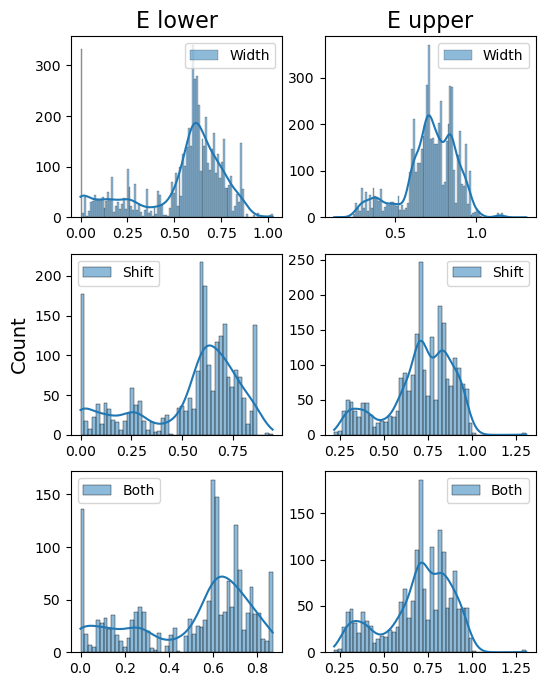

In [712]:
data_width_fraction = data_width.copy()
data_shift_fraction = data_shift.copy()
data_both_fraction  = data_both.copy()

data_width_fraction['E lower'], data_width_fraction['E upper'] = energy_to_fraction(data_width_fraction, 'E lower'), energy_to_fraction(data_width_fraction, 'E upper')
data_shift_fraction['E lower'], data_shift_fraction['E upper'] = energy_to_fraction(data_shift_fraction, 'E lower'), energy_to_fraction(data_shift_fraction, 'E upper')
data_both_fraction['E lower'], data_both_fraction['E upper']   = energy_to_fraction(data_both_fraction, 'E lower'), energy_to_fraction(data_both_fraction, 'E upper')

fig, ax = plt.subplots(3, 2, figsize = (6, 8))

sns.histplot(data = data_width_fraction, x = 'E lower', ax = ax[0, 0], log_scale=False, bins = 100, kde = True, label = 'Width')
sns.histplot(data = data_width_fraction, x = 'E upper', ax = ax[0, 1], log_scale=False, bins = 100, kde = True, label = 'Width')
sns.histplot(data = data_shift_fraction, x = 'E lower', ax = ax[1, 0], log_scale=False, bins = 50, kde = True, label = 'Shift')
sns.histplot(data = data_shift_fraction, x = 'E upper', ax = ax[1, 1], log_scale=False, bins = 50, kde = True, label = 'Shift')
sns.histplot(data = data_both_fraction,  x = 'E lower', ax = ax[2, 0], log_scale=False, bins = 50, kde = True, label = 'Both')
sns.histplot(data = data_both_fraction,  x = 'E upper', ax = ax[2, 1], log_scale=False, bins = 50, kde = True, label = 'Both')

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i, j].set_xlabel(None)
        ax[i, j].set_ylabel(None)
        ax[i, j].legend()
        
#ax[2, 0].set_xlabel('Energy ($cm^{-1}$)', fontsize = 14)
#ax[2, 1].set_xlabel('Energy ($cm^{-1}$)', fontsize = 14)
ax[1, 0].set_ylabel('Count', fontsize = 14)

ax[0, 0].set_title('E lower', fontsize = 16)
ax[0, 1].set_title('E upper', fontsize = 16)
plt.show()

In [706]:
#Inspection of those entries that have E_upper in terms of fraction of ionization energy larger than 1
data_width_fraction.loc[(data_width_fraction['E upper'] >= 1) & (data_width_fraction['Element'] == 'Br')][['Element', 'Charge', 'Wavelength', 'E lower', 'E upper']]
data_both_fraction.loc[(data_both_fraction['E upper'] >= 1)][['Element', 'Charge', 'Wavelength', 'E lower', 'E upper']].sort_values(by = ['E upper'])

,Element,Charge,Wavelength,E lower,E upper
6413,Si,1,570.137,0.867179,1.000182
6414,Si,1,570.137,0.867179,1.000182
6411,Si,1,568.881,0.867842,1.001138
6412,Si,1,568.881,0.867842,1.001138
832,Cu,0,427.511,0.626132,1.001385
840,Cu,0,465.112,0.656469,1.001385
6409,Si,1,566.956,0.868711,1.002460
6410,Si,1,566.956,0.868711,1.002460
836,Cu,0,453.970,0.666960,1.020342
621,Mg,0,291.545,0.752429,1.308443


In [707]:
#E upper > E lower
data.loc[data['E upper'] <= data['E lower']][['Element', 'Charge', 'Wavelength', 'E lower', 'E upper']].sort_values(by = ['E upper'])

,Element,Charge,Wavelength,E lower,E upper


In [708]:
#Parity (lower) != Parity (upper)
data.loc[data['Parity'] == data['Parity.1']][['Element', 'Charge', 'Wavelength', 'E lower', 'Parity', 'Parity.1', 'E upper']].sort_values(by = ['E upper'])

,Element,Charge,Wavelength,E lower,Parity,Parity.1,E upper


In [631]:
#Wavelength equal to energy difference
data.loc[(1/(data['E upper'] - data['E lower'])*1e7 - data['Wavelength']).abs() >= 0.5][['Element', 'Charge', 'Wavelength', 'E lower', 'Parity', 'Parity.1', 'E upper']].sort_values(by = ['Charge', 'Element'])

,Element,Charge,Wavelength,E lower,Parity,Parity.1,E upper


In [646]:
#Sum of electron on the lower level equals to the sum on the upper level
c_lower = ['1s', '2s', '2p', '3s','3p', '3d', '4s', '4p', '4d', '4f', '5s', '5p', '5d', '5f', '5g', '6s', '6p', '6d', '7s',
           '7p', '7d']
c_upper = ['1s.1', '2s.1', '2p.1', '3s.1', '3p.1', '3d.1', '4s.1', '4p.1', '4d.1', '4f.1', '5s.1', '5p.1', '5d.1', '5f.1',
           '5g.1', '6s.1', '6p.1', '6d.1', '6f', '6g', '6h', '7s.1', '7p.1', '7d.1', '8s', '8p', '8d', '9s', '10s', '11s']

data.loc[data[c_lower].sum(axis=1) != data[c_upper].sum(axis=1)][['Element', 'Charge', 'Wavelength', 'E lower', 'Parity', 'Parity.1', 'E upper']].sort_values(by = ['Charge', 'Element'])

,Element,Charge,Wavelength,E lower,Parity,Parity.1,E upper


In [671]:
#Multiplicity >0
data.loc[data['Multiplicity.1'] == 0][['Element', 'Charge', 'Wavelength', 'E lower', 'Parity', 'Parity.1', 'E upper']].sort_values(by = ['Charge', 'Element'])

,Element,Charge,Wavelength,E lower,Parity,Parity.1,E upper


In [680]:
#Parity 0 or 1
data.loc[data['Parity.1'] == 2][['Element', 'Charge', 'Wavelength', 'E lower', 'Parity', 'Parity.1', 'E upper']].sort_values(by = ['Charge', 'Element'])

,Element,Charge,Wavelength,E lower,Parity,Parity.1,E upper


In [705]:
#Change of J in a transition = 0, +1 or -1
data.loc[(data['J'] - data['J.1']).abs() > 1][['Element', 'Charge', 'Wavelength', 'E lower', 'Parity', 'Parity.1', 'E upper']].sort_values(by = ['Charge', 'Element'])

,Element,Charge,Wavelength,E lower,Parity,Parity.1,E upper


## Distribution of each variable

In [12]:
print(sns.color_palette('colorblind').as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


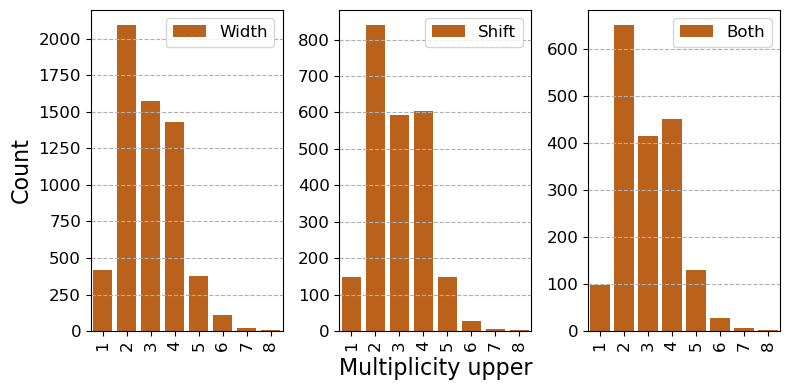

In [177]:
item = 'Multiplicity.1'
uporlow = 'upper'

fig, ax = plt.subplots(1, 3, figsize = (8, 4))
sns.countplot(data = data_width, x = f'{item}', ax = ax[0], label = 'Width', color = '#d55e00')
sns.countplot(data = data_shift, x = f'{item}', ax = ax[1], label = 'Shift', color = '#d55e00')
sns.countplot(data = data_both,  x = f'{item}', ax = ax[2], label = 'Both', color = '#d55e00')

for i in range(len(ax)):
    ax[i].legend(fontsize = 'large', loc = 'upper right')
    ax[i].tick_params(axis = 'both', labelsize = 12)
    #ax[i].tick_params(axis = 'x', labelrotation = 90)
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)

ax[1].set_xlabel(f"{item[:-2]} {uporlow}", fontsize = 16)
ax[0].set_ylabel('Count', fontsize = 16)

ax[0].grid(which = 'major', axis = 'y', ls = '--')
ax[1].grid(which = 'major', axis = 'y', ls = '--')
ax[2].grid(which = 'major', axis = 'y', ls = '--')

plt.tight_layout()
plt.savefig(f"{item[:-2]} {uporlow}.svg", dpi = 300, transparent = True, format = 'svg')
plt.show()

# Unique wavelength

Cu 204.38 nm; 1 data points


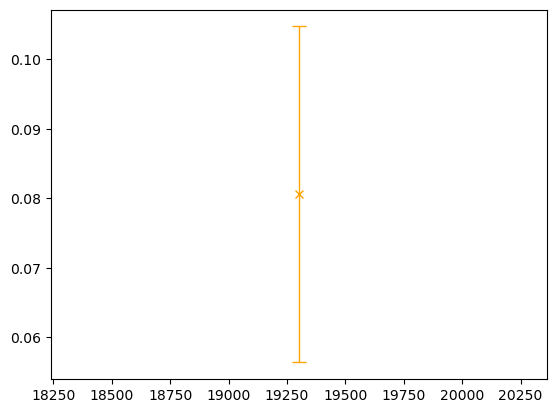

In [44]:
list_wavel = list(data['Wavelength'].value_counts().index)

idx = -1767
line_data = data.loc[data['Wavelength'] == list_wavel[idx]]
print(line_data['Element'].iloc[0], line_data['Wavelength'].iloc[0], 'nm;', line_data.shape[0], 'data points')

fig, ax = plt.subplots()
ax.plot(line_data['T'], line_data['w (A)'], color = 'orange', ls = 'None', marker = 'x')
ax.errorbar(line_data.loc[line_data['w error (%)'].isna() == False]['T'],
           line_data.loc[line_data['w error (%)'].isna() == False]['w (A)'],
           yerr = line_data.loc[line_data['w error (%)'].isna() == False]['w error (%)']/100*line_data.loc[line_data['w error (%)'].isna() == False]['w (A)'],
           color = 'orange', ls = 'None', capsize=5, lw = 1)

plt.show()

In [18]:
line_data['T'].describe()

count       39.000000
mean     26388.461538
std       8775.912470
min      14600.000000
25%      19150.000000
50%      22700.000000
75%      34900.000000
max      42050.000000
Name: T, dtype: float64

In [14]:
data['Wavelength'].nunique()

2883

In [86]:
line_data.loc[line_data['w error (%)'].isna() == False][['T', 'w (A)', 'w error (%)']]

,T,w (A),w error (%)
57,19000,8.750000,23.0
58,19100,8.595745,23.0
59,19200,8.401487,23.0
60,19300,8.800000,23.0
61,21400,9.411765,23.0
62,22100,7.881944,23.0
63,22700,9.555556,15.0
64,23600,9.661017,15.0
65,26700,8.732394,23.0
66,27600,8.395062,23.0
